# Active Testing on Box level

data prepared from prepare_box_data.ipynb
results store in ./results/active_test_box_level

In [8]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path
import os, sys
import numpy as np
import torch

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops
import pickle
import copy
import random
from util.utils import slprint, to_device
import util.misc as utils
from engine import evaluate
from torch.utils.data import DataLoader
from datasets import build_dataset, get_coco_api_from_dataset

In [2]:
def read_one_image_results(path):
    with open(path, "r") as outfile:
        data = json.load(outfile)
    return data

def write_one_results(path, json_data):
    with open(path, "w") as outfile:
        json.dump(json_data, outfile)
        
def transform_tensor_to_list(l):
    return l.cpu().tolist()

def transform_tensors_to_list(l):
    if torch.is_tensor(l):
        return transform_tensor_to_list(l)
    if isinstance(l, list):
        r = []
        for i in l:
            r.append(transform_tensors_to_list(i))
        return r
    if isinstance(l, dict):
        r = {}
        for k,v in l.items():
            r[k] = transform_tensors_to_list(v)
        return r
    return l

def LURE_weights_for_risk_estimator(weights, N):
    M = weights.size
    if M < N:
        m = np.arange(1, M+1)
        v = (
            1
            + (N-M)/(N-m) * (
                    1 / ((N-m+1) * weights)
                    - 1
                    )
            )
    else:
        v = 1

    return v

def get_one_annotation_values(path, key, file_num = 5000):
    results = []
    for img_idx in range(file_num):
        file_path = os.path.join(path, str(img_idx)+".json")
        data = read_one_image_results(file_path)
        if data[key] != None:
            results.extend(data[key])
        else:
            # print(f"{file} don't have this data")
            result = [-1]*len(data['loss'])
            results.extend(result)
    return np.array(results)

def get_img_idxes(path, file_num = 5000):
    results = []
    for img_idx in range(file_num):
        file_path = os.path.join(path, str(img_idx)+".json")
        data = read_one_image_results(file_path)
        result = [img_idx] * len(data['loss'])
        results.extend(result)
    return np.array(results)

def acquire(expected_loss_inputs, samples_num):
    assert samples_num <= expected_loss_inputs.size
    expected_loss = np.copy(expected_loss_inputs)
    # Log-lik can be negative.
    # Make all values positive.
    if (expected_loss < 0).sum() > 0:
        expected_loss += np.abs(expected_loss.min())
    
    if np.any(np.isnan(expected_loss)):
        logging.warning(
            'Found NaN values in expected loss, replacing with 0.')
        logging.info(f'{expected_loss}')
        expected_loss = np.nan_to_num(expected_loss, nan=0)
    pick_sample_idxs = np.zeros((samples_num), dtype = int)
    idx_array = np.arange(expected_loss.size)
    weights = np.zeros((samples_num), dtype = np.single)
    uniform_clip_val = 0.2
    for i in range(samples_num):
        expected_loss /= expected_loss.sum()
        # clip all values less than 10 percent of uniform propability
        expected_loss = np.maximum(uniform_clip_val * 1/expected_loss.size, expected_loss)
        expected_loss /= expected_loss.sum()
        sample = np.random.multinomial(1, expected_loss)
        cur_idx = np.where(sample)[0][0]
        # cur_idx = np.random.randint(expected_loss.size)
        pick_sample_idxs[i] = idx_array[cur_idx]
        weights[i] = expected_loss[cur_idx]
        selected_mask = np.ones((expected_loss.size), dtype=bool)
        selected_mask[cur_idx] = False
        expected_loss = expected_loss[selected_mask]
        idx_array = idx_array[selected_mask]
    return pick_sample_idxs, weights

def run_one_random_sample_risk_estimator(true_losses, seed, samples_num):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    perm = np.random.permutation(true_losses.size)
    pick_sample_idxs = perm[:samples_num]
    sampled_true_losses = true_losses[pick_sample_idxs]
    return sampled_true_losses.mean()

def run_one_random_sample_without_repeated_risk_estimator(true_losses, img_idxes, label_idxes, seed, samples_num):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    assert true_losses.size == img_idxes.size
    assert true_losses.size == label_idxes.size
    idx_array = np.arange(true_losses.size)
    count = 0
    choose_loss = []
    choose_box_idx = {}
    while count < samples_num:
        idx = np.random.randint(idx_array.size, size=1)
        real_idx = idx_array[idx]
        choose_loss.extend(true_losses[real_idx].tolist())
        img_idx = int(img_idxes[real_idx])
        lable_idx = int(label_idxes[real_idx])
        selected_masked = np.ones(idx_array.shape, dtype=bool)
        selected_masked[idx] = False
        idx_array = idx_array[selected_masked]
        if img_idx in choose_box_idx:
            if lable_idx in choose_box_idx[img_idx]:
                continue
            choose_box_idx[img_idx].append(lable_idx)
        else:
            choose_box_idx[img_idx] = [lable_idx]
        count += 1
    return np.array(choose_loss).mean()

def change_loss_to_image_level(true_losses, img_idxes):
    losses = []
    assert true_losses.size == img_idxes.size
    index = 0
    for i in range(5000):
        loss = []
        while index < img_idxes.size and img_idxes[index] == i:
            loss.append(true_losses[index])
            index += 1
        losses.append(loss)
    return losses

def dataset_label_num_lists(dataset):
    label_nums = []
    for i in range(len(dataset)):
        _, target = dataset[i]
        label_nums.append(target['labels'].shape[0])
    return label_nums

def run_one_random_sample_risk_estimator_for_image_based(true_losses, label_nums, seed, samples_num):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    perm = np.random.permutation(len(true_losses))
    sampled_true_losses = []
    count_label_num = 0
    for i in range(perm.shape[0]):
        if count_label_num >= samples_num:
            break
        sampled_true_losses.extend(true_losses[perm[i]])
        count_label_num += label_nums[perm[i]]
    sampled_true_losses = np.array(sampled_true_losses)
    return sampled_true_losses.mean()

def np_read(file):
    with open(file, "rb") as outfile:
        data = np.load(outfile)
    return data
def np_write(data, file):
    with open(file, "wb") as outfile:
        np.save(outfile, data)

In [3]:
split = "val"
base_path = "./data/5_scale_31/" + split
data_path = base_path + "/data/"
annotation_path = base_path + "/box_annotation/"
result_json_path = "./results/active_test_box_level_VIT/"
true_losses = np_read(base_path + "/feature_pre_data/annotation.npy")
# 36335
box_labels_nums = true_losses.shape[0]
sample_size_precentage = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
sample_size_set = (np.array(sample_size_precentage) * box_labels_nums).astype(int).tolist()
# sample_size_set = [50, 100, 150, 200, 250, 500, 750, 1000, 1500, 2000, 3000]
# simple_size_precent = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3]
# random_seed_set = [4519, 9524, 5901, 1028, 6382, 5383, 5095, 7635,  890,  608]
random_seed_set = [4519, 9524, 5901]                      
normalize_list = {"loss_bbox": [0.09300409561655773, 0.0767726528828114], "loss_ce": [0.3522786986406354, 0.7470140154753052], 
                  "loss_giou": [1.1611697194208146, 0.47297514438862676], "loss": [3.1396386155214007, 1.4399662609117525]}

In [4]:
losses = get_one_annotation_values(annotation_path, "loss")
label_idxes = get_one_annotation_values(annotation_path, "matched_target_indexes")
img_idxes = get_img_idxes(annotation_path)

## Active Testing

In [5]:
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
import sklearn
import random
from util.box_ops import box_cxcywh_to_xyxy, generalized_box_iou

In [6]:
def hungarian_matching(out_logits, out_boxes, tgt_ids, tgt_bbox, cost_class = 2.0, cost_bbox = 5.0, cost_giou = 2.0, focal_alpha = 0.25):
    """ Performs the matching
    """
    # We flatten to compute the cost matrices in a batch
    num_queries = out_logits.shape[0]
    out_prob = out_logits.sigmoid()  # [num_queries, num_classes]
    
    # Compute the classification cost.
    alpha = focal_alpha
    gamma = 2.0
    neg_cost_class = (1 - alpha) * (out_prob ** gamma) * (-(1 - out_prob + 1e-8).log())
    pos_cost_class = alpha * ((1 - out_prob) ** gamma) * (-(out_prob + 1e-8).log())
    cost_class = pos_cost_class[:, tgt_ids] - neg_cost_class[:, tgt_ids]
    
    # Compute the L1 cost between boxes
    cost_bbox = torch.cdist(out_boxes, tgt_bbox, p=1)
    
    # Compute the giou cost betwen boxes            
    cost_giou = -generalized_box_iou(box_cxcywh_to_xyxy(out_boxes), box_cxcywh_to_xyxy(tgt_bbox))
    
    # Final cost matrix
    C = cost_bbox * cost_bbox + cost_class * cost_class + cost_giou * cost_giou
    C = C.view(num_queries, -1)
    return C

def get_numpy_data_for_regression(data_path, annotation_path, img_nums):
    X = None
    Y = None
    for img_idx in range(img_nums):
        results = read_one_image_results(data_path + str(img_idx) + ".json")
        pred_logits = torch.FloatTensor(results['input']['pred_logits']).squeeze(axis=0)
        pred_boxes = torch.FloatTensor(results['input']['pred_boxes']).squeeze(axis=0)
        prob = pred_logits.sigmoid()
        labels = pred_logits.argmax(axis=1)
        annotation_data = read_one_image_results(annotation_path + str(img_idx) + ".json")
        selected_index = annotation_data['selected_index']
        out_logits = pred_logits[selected_index]
        out_boxes = pred_boxes[selected_index]
        cost_matrix = hungarian_matching(out_logits, out_boxes, labels, pred_boxes)
        topk_values, topk_indexes = torch.topk(-cost_matrix, 9, dim=1)
        one_X = None
        for i in range(topk_indexes.shape[0]):
            surrgate_logits = pred_logits[topk_indexes[i]]
            surrgate_boxes = pred_boxes[topk_indexes[i]]
            surrgate_data = torch.cat((surrgate_logits, surrgate_boxes), axis=1)
            self_data = torch.cat((out_logits[i], out_boxes[i])).unsqueeze(0)
            one_temp_X = torch.cat((self_data, surrgate_data), axis=0)
            one_temp_X = one_temp_X.reshape((1,-1))
            if one_X == None:
                one_X = one_temp_X
            else:
                one_X = torch.cat((one_X, one_temp_X), axis=0)
        if X == None:
            X = one_X
        else:
            X = torch.cat((X, one_X), axis=0)
        loss = annotation_data['loss']
        loss = np.array(loss)
        if Y is None:
            Y = loss
        else:
            Y = np.concatenate((Y, loss))
        if img_idx % 100 == 0:
            print(f"{img_idx} finished")
    X = X.numpy()
    return X, Y


def get_expected_loss(inputs, model):
    expected_loss = model.predict(inputs)
    return expected_loss

def run_one_approximate_risk_estimator(true_losses, expected_losses, seed, samples_num):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    pick_sample_idxs, weights = acquire(expected_losses, samples_num)
    risk_estimator_weights = LURE_weights_for_risk_estimator(weights, expected_losses.size)
    sampled_true_losses = true_losses[pick_sample_idxs]

    loss_risk = (sampled_true_losses * risk_estimator_weights).mean()
    return loss_risk

def acquire_without_repeated(expected_loss_inputs, img_idxes, label_idxes, samples_num):
    assert expected_loss_inputs.size == img_idxes.size
    assert expected_loss_inputs.size == label_idxes.size
    assert samples_num <= expected_loss_inputs.size
    expected_loss = np.copy(expected_loss_inputs)
    # Log-lik can be negative.
    # Make all values positive.
    if (expected_loss < 0).sum() > 0:
        expected_loss += np.abs(expected_loss.min())
    if np.any(np.isnan(expected_loss)):
        logging.warning(
            'Found NaN values in expected loss, replacing with 0.')
        logging.info(f'{expected_loss}')
        expected_loss = np.nan_to_num(expected_loss, nan=0)
    idx_array = np.arange(expected_loss.size)
    weights = []
    pick_sample_idxs = []
    count = 0
    uniform_clip_val = 0.2
    choose_box_idx = {}
    while count < samples_num:
        expected_loss /= expected_loss.sum()
        expected_loss = np.maximum(uniform_clip_val * 1/expected_loss.size, expected_loss)
        expected_loss /= expected_loss.sum()
        sample = np.random.multinomial(1, expected_loss)
        idx = np.where(sample)[0][0]
        real_idx = idx_array[idx]
        weights.append(expected_loss[idx])
        selected_mask = np.ones((expected_loss.size), dtype=bool)
        selected_mask[idx] = False
        expected_loss = expected_loss[selected_mask]
        idx_array = idx_array[selected_mask]
        img_idx = int(img_idxes[real_idx])
        lable_idx = int(label_idxes[real_idx])
        pick_sample_idxs.append(real_idx)
        if img_idx in choose_box_idx:
            if lable_idx in choose_box_idx[img_idx]:
                continue
            choose_box_idx[img_idx].append(lable_idx)
        else:
            choose_box_idx[img_idx] = [lable_idx]
        count += 1
    return np.array(pick_sample_idxs), np.array(weights)

def run_one_approximate_risk_estimator_without_repeated(true_losses, expected_losses, img_idxes, label_idxes, seed, samples_num):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    pick_sample_idxs, weights = acquire_without_repeated(expected_losses, img_idxes, label_idxes, samples_num)
    risk_estimator_weights = LURE_weights_for_risk_estimator(weights, expected_losses.size)
    sampled_true_losses = true_losses[pick_sample_idxs]

    loss_risk = (sampled_true_losses * risk_estimator_weights).mean()
    return loss_risk

def active_testing(file_path, true_losses, expected_losses, active_test_type):
    json_object = {}
    for sample_size in sample_size_set:
        for seed in random_seed_set:
            result = {"active_test_type": active_test_type, "sample_size": sample_size}
            loss_risk = run_one_approximate_risk_estimator(true_losses, expected_losses, seed, sample_size)
            result["loss"] = loss_risk
            json_object[len(json_object)] = result
    with open(file_path, "w") as outfile:
        json.dump(json_object, outfile)

def active_testing_without_repeated(file_path, true_losses, expected_losses, active_test_type, img_idxes, label_idxes):
    json_object = {}
    for sample_size in sample_size_set:
        for seed in random_seed_set:
            result = {"active_test_type": active_test_type, "sample_size": sample_size}
            loss_risk = run_one_approximate_risk_estimator_without_repeated(true_losses, expected_losses, img_idxes, label_idxes, seed, sample_size)
            result["loss"] = loss_risk
            json_object[len(json_object)] = result
    with open(file_path, "w") as outfile:
        json.dump(json_object, outfile)

## Vision Transformer based

In [7]:
# train all ViT parameters
estimated_loss_path = "../../ViT-pytorch/output/ViT-feature-det-ordinal_losses_40000.json"
estimated_loss = np.array(read_one_image_results(estimated_loss_path)['losses'])
file_path = result_json_path + "ViT_runs_40000.json"
active_testing_without_repeated(file_path, true_losses, estimated_loss, "ViT", img_idxes, label_idxes)

In [22]:
# estimated_loss_path = "/workspace/ViT-pytorch/output/ViT-feature-Nearest-train-60000-scale_losses.json"
# estimated_loss = np.array(read_one_image_results(estimated_loss_path)['losses'])
# estimated_loss = estimated_loss * normalize_list['loss'][1] + normalize_list['loss'][0]
# file_path = result_json_path + "ViT_feature_train_scale_R50_31_10_runs.json"
# active_testing_without_repeated(file_path, losses, estimated_loss, "ViT feature", img_idxes, label_idxes)

## Random Sample risk estimation

In [5]:
def run_one_random_sample_risk_estimator(true_losses, seed, samples_num):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    perm = np.random.permutation(true_losses.size)
    pick_sample_idxs = perm[:samples_num]
    sampled_true_losses = true_losses[pick_sample_idxs]
    return sampled_true_losses.mean()

In [40]:
# The required label might be repeated
file_path = result_json_path + "random_sample_repeated_R50_31_10_runs.json"
json_object = {}
for sample_size in sample_size_set:
    for seed in random_seed_set:
        result = {"active_test_type": "random sample repeated", "sample_size": sample_size}
        loss_risk = run_one_random_sample_risk_estimator(true_losses, seed, sample_size)
        result["loss"] = loss_risk
        json_object[len(json_object)] = result
with open(file_path, "w") as outfile:
    json.dump(json_object, outfile)

In [10]:
def run_one_random_sample_without_repeated_risk_estimator(true_losses, img_idxes, label_idxes, seed, samples_num):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    assert true_losses.size == img_idxes.size
    assert true_losses.size == label_idxes.size
    idx_array = np.arange(true_losses.size)
    count = 0
    choose_loss = []
    choose_box_idx = {}
    while count < samples_num:
        idx = np.random.randint(idx_array.size, size=1)
        real_idx = idx_array[idx]
        choose_loss.extend(true_losses[real_idx].tolist())
        img_idx = int(img_idxes[real_idx])
        lable_idx = int(label_idxes[real_idx])
        selected_masked = np.ones(idx_array.shape, dtype=bool)
        selected_masked[idx] = False
        idx_array = idx_array[selected_masked]
        if img_idx in choose_box_idx:
            if lable_idx in choose_box_idx[img_idx]:
                continue
            choose_box_idx[img_idx].append(lable_idx)
        else:
            choose_box_idx[img_idx] = [lable_idx]
        count += 1
    return np.array(choose_loss).mean()

In [11]:
# The required label won't be repeated
file_path = result_json_path + "random_sample_R50_31_10_runs.json"
json_object = {}
for sample_size in sample_size_set:
    for seed in random_seed_set:
        result = {"active_test_type": "random sample", "sample_size": sample_size}
        loss_risk = run_one_random_sample_without_repeated_risk_estimator(true_losses, img_idxes, label_idxes, seed, sample_size)
        result["loss"] = loss_risk
        json_object[len(json_object)] = result
with open(file_path, "w") as outfile:
    json.dump(json_object, outfile)

## Random Sample with image level but set the threshold for box level

In [43]:
%%capture
model_config_path = "config/DINO/DINO_5scale.py"
args = SLConfig.fromfile(model_config_path) 
args.dataset_file = 'coco'
args.coco_path = "../coco/" # the path of coco
args.fix_size = False

dataset_val = build_dataset(image_set="val", args=args)   

In [7]:
def change_loss_to_image_level(true_losses, img_idxes):
    losses = []
    assert true_losses.size == img_idxes.size
    index = 0
    for i in range(5000):
        loss = []
        while index < img_idxes.size and img_idxes[index] == i:
            loss.append(true_losses[index])
            index += 1
        losses.append(loss)
    return losses

def dataset_label_num_lists(dataset):
    label_nums = []
    for i in range(len(dataset)):
        _, target = dataset[i]
        label_nums.append(target['labels'].shape[0])
    return label_nums

def run_one_random_sample_risk_estimator_for_image_based(true_losses, label_nums, seed, samples_num):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    perm = np.random.permutation(len(true_losses))
    sampled_true_losses = []
    count_label_num = 0
    for i in range(perm.shape[0]):
        if count_label_num >= samples_num:
            break
        sampled_true_losses.extend(true_losses[perm[i]])
        count_label_num += label_nums[perm[i]]
    sampled_true_losses = np.array(sampled_true_losses)
    return sampled_true_losses.mean()

In [62]:
image_based_losses = change_loss_to_image_level(losses, img_idxes)
label_nums = dataset_label_num_lists(dataset_val)

In [63]:
file_path = result_json_path + "random_sample_image_level_R50_31_10_runs.json"
json_object = {}
for sample_size in sample_size_set:
    for seed in random_seed_set:
        result = {"active_test_type": "random sample image level", "sample_size": sample_size}
        loss_risk = run_one_random_sample_risk_estimator_for_image_based(image_based_losses, label_nums, seed, sample_size)
        result["loss"] = loss_risk
        json_object[len(json_object)] = result
with open(file_path, "w") as outfile:
    json.dump(json_object, outfile)

## Whole data set risk estimation

In [12]:
def get_whole_data_set_risk_estimator(true_losses):
    return true_losses.mean()

In [13]:
file_path = result_json_path + "None_R50_31.json"
result = {"active_test_type": "None", "sample_size": true_losses.size}
result["loss"] = get_whole_data_set_risk_estimator(true_losses)
json_object = {}
json_object[0] = result
with open(file_path, "w") as outfile:
    json.dump(json_object, outfile)

## Try using sklearn model to estimate loss

In [11]:
# train_data_path = "./data/5_scale_31/train/data/"
# test_data_path = "./data/5_scale_31/val/data/"
# train_annotation_path = "./data/5_scale_31/train/box_annotation/"
# test_annotation_path = "./data/5_scale_31/val/box_annotation/"

In [ ]:
# train_X, train_Y = get_numpy_data_for_regression(train_data_path, train_annotation_path, 10000)

In [42]:
# split = "train"
# store_preprocess_inputs_path = "./data/5_scale_31/" + split + f"/pre_data/{split}_box_level_inputs.npy"
# with open(store_preprocess_inputs_path, "wb") as outfile:
#     np.save(outfile, train_X)
# store_preprocess_annotations_path = "./data/5_scale_31/" + split + f"/pre_data/{split}_box_level_annotations.npy"
# with open(store_preprocess_annotations_path, "wb") as outfile:
#     np.save(outfile, train_Y)

In [ ]:
# test_X, test_Y = get_numpy_data_for_regression(test_data_path, test_annotation_path, 5000)

In [15]:
# split = "val"
# store_preprocess_inputs_path = "./data/5_scale_31/" + split + f"/pre_data/{split}_box_level_inputs.npy"
# with open(store_preprocess_inputs_path, "wb") as outfile:
#     np.save(outfile, test_X)
# store_preprocess_annotations_path = "./data/5_scale_31/" + split + f"/pre_data/{split}_box_level_annotations.npy"
# with open(store_preprocess_annotations_path, "wb") as outfile:
#     np.save(outfile, test_Y)

## Redge Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge

In [12]:
with open("./data/5_scale_31/train" + f"/pre_data/train_box_level_inputs.npy", 'rb') as outfile:
    train_X = np.load(outfile)
train_X = train_X.reshape((train_X.shape[0], -1))
with open("./data/5_scale_31/train" + f"/pre_data/train_box_level_annotations.npy", 'rb') as outfile:
    train_Y = np.load(outfile)
with open("./data/5_scale_31/val" + f"/pre_data/val_box_level_inputs.npy", 'rb') as outfile:
    test_X = np.load(outfile)
test_X = test_X.reshape((test_X.shape[0], -1))
with open("./data/5_scale_31/val" + f"/pre_data/val_box_level_annotations.npy", 'rb') as outfile:
    test_Y = np.load(outfile)

In [13]:
from sklearn.linear_model import RidgeCV
redge_reg = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
redge_reg.fit(train_X, train_Y)

RidgeCV(alphas=array([0.001, 0.01 , 0.1  , 1.   ]))

In [14]:
redge_reg.score(test_X, test_Y)

0.02169827020655135

In [50]:
true_losses = test_Y
expected_losses = get_expected_loss(test_X, redge_reg)
file_path = result_json_path + "RedgeReg_repeated_R50_31_10_runs.json"
active_testing(file_path, true_losses, expected_losses, "RR repeated")

In [15]:
true_losses = test_Y
expected_losses = get_expected_loss(test_X, redge_reg)
file_path = result_json_path + "RedgeReg_R50_31_10_runs.json"
active_testing_without_repeated(file_path, true_losses, expected_losses, "RR", img_idxes, label_idxes)

In [34]:
# loss_analysis_path = "./results/loss_analysis/" + "box_based_regde_regression.json"
# json_object = {"true loss": true_losses.tolist(), "estimated loss": expected_losses.tolist()}
# write_one_results(loss_analysis_path, json_object)

## Redge Regression with feature

In [40]:
def read_one_json_results(path):
    with open(path, "r") as outfile:
        data = json.load(outfile)
    return data

def np_read(file):
    with open(file, "rb") as outfile:
        data = np.load(outfile)
    return data

def np_write(data, file):
    with open(file, "wb") as outfile:
        np.save(outfile, data)

def read_feature(path, nums):
    one_feature = np.array(read_one_json_results(feature_pre_data+ "0.json")["self_feature"])
    features = np.zeros((nums, one_feature.shape[1]))
    for index in range(nums):
        one_feature = np.array(read_one_json_results(feature_pre_data+ str(index)+".json")["self_feature"])
        features[index] = one_feature
    return features

In [35]:
feature_pre_data = "./data/5_scale_31/train/feature_pre_data/"
train_Y = np_read(feature_pre_data + "annotation.npy")
train_X = read_feature(feature_pre_data, train_Y.shape[0])

In [36]:
feature_pre_data = "./data/5_scale_31/val/feature_pre_data/"
test_Y = np_read(feature_pre_data + "annotation.npy")
test_X = read_feature(feature_pre_data, test_Y.shape[0])

In [37]:
from sklearn.linear_model import RidgeCV
redge_reg = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
redge_reg.fit(train_X, train_Y)

RidgeCV(alphas=array([0.001, 0.01 , 0.1  , 1.   ]))

In [38]:
redge_reg.score(test_X, test_Y)

0.11180959630535592

In [39]:
true_losses = test_Y
expected_losses = get_expected_loss(test_X, redge_reg)
file_path = result_json_path + "RedgeReg_feature_R50_31_10_runs.json"
active_testing_without_repeated(file_path, true_losses, expected_losses, "RR", img_idxes, label_idxes)

In [41]:
np_write(expected_losses, "./results/loss_analysis/box_based_ridge_regression_feature.npy")

## MLP with feature

In [44]:
from torch.utils.data import DataLoader, DistributedSampler, random_split, TensorDataset
from torch import nn
class MPLNet(nn.Module):
    def __init__(self, input_dims = 10000, output_dims = 1, dropout = 0.1):
        super().__init__()
        self.layer2=nn.Linear(input_dims, 1000)
        self.layer3=nn.Linear(1000, 100)
        self.layer4=nn.Linear(100, 10)
        self.layer5=nn.Linear(10, 1)
        self.norm2 = nn.LayerNorm(1000)
        self.norm3 = nn.LayerNorm(100)
        self.norm4 = nn.LayerNorm(10)
        self._init_parms(self.layer2)
        self._init_parms(self.layer3)
        self._init_parms(self.layer4)
        self._init_parms(self.layer5)
        # self.dropout1 = nn.Dropout(dropout)
        # self.dropout2 = nn.Dropout(dropout)
        # self.dropout3 = nn.Dropout(dropout)
        self.input_dims = input_dims
    
    def _init_parms(self, module):
        module.weight.data.normal_(mean=0.0, std=1.0)
        
    def forward(self, x):
        x=x.view(-1, self.input_dims)
        x=nn.functional.relu(self.norm2(self.layer2(x)))
        x=nn.functional.relu(self.norm3(self.layer3(x)))
        x=nn.functional.relu(self.norm4(self.layer4(x)))
        x=self.layer5(x)
        return x

device_name = "cuda:1"
device = torch.device(device_name)
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
rate_learning = 1e-4
model = MPLNet(input_dims=1536)
loss_function = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=rate_learning)
model.to(device)

MPLNet(
  (layer2): Linear(in_features=1536, out_features=1000, bias=True)
  (layer3): Linear(in_features=1000, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=10, bias=True)
  (layer5): Linear(in_features=10, out_features=1, bias=True)
  (norm2): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (norm4): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
)

In [48]:
# load data
batch_size = 100
inputs = torch.from_numpy(train_X)
annotations = torch.from_numpy(train_Y)
datasets = TensorDataset(inputs, annotations)
datasets_nums = inputs.shape[0]
train_nums = int(datasets_nums * 0.7)
train_datasets, val_datasets = torch.utils.data.random_split(datasets, [train_nums, datasets_nums-train_nums])
train_sampler = torch.utils.data.RandomSampler(train_datasets)
batch_sampler_train = torch.utils.data.BatchSampler(train_sampler, batch_size, drop_last=True)
train_dataloader = DataLoader(train_datasets, batch_sampler=batch_sampler_train)

val_sampler = torch.utils.data.SequentialSampler(val_datasets)
valid_dataloader = DataLoader(val_datasets, 1, sampler=val_sampler, drop_last=False)

In [50]:
for epoch in range(10):

    # Performing Training for each epoch
    training_loss = 0.
    model.train()

    # The training loop
    for step, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        input, label = batch
        input = input.to(device=device_name).type(torch.float)
        label = label.to(device=device_name).type(torch.float)[None, :]
        output = model(input)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        if step % 10000 == 0:
            print("Train Epoch: {}, Step: {}, Loss {}".format(epoch, step, loss.item()))


    # Performing Validation for each epoch
    validation_loss = 0.
    model.eval()

    # The validation loop
    for batch in valid_dataloader:
        input, label = batch
        input = input.to(device=device_name).type(torch.float)
        label = label.to(device=device_name).type(torch.float)[None, :]
        output = model(input)
        loss = loss_function(output, label)
        validation_loss += loss.item()

    # Calculating the average training and validation loss over epoch
    training_loss_avg = training_loss/len(train_dataloader)
    validation_loss_avg = validation_loss/len(valid_dataloader)

    # Printing average training and average validation losses
    print("Epoch: {}".format(epoch))
    print("Training loss: {}".format(training_loss_avg))
    print("Validation loss: {}".format(validation_loss_avg))

Train Epoch: 0, Step: 0, Loss 1.9148993492126465
Epoch: 0
Training loss: 2.071711402107717
Validation loss: 2.0650121677309454
Train Epoch: 1, Step: 0, Loss 2.1761560440063477
Epoch: 1
Training loss: 2.0716718355521513
Validation loss: 2.0647357225670593
Train Epoch: 2, Step: 0, Loss 2.6170666217803955
Epoch: 2
Training loss: 2.071611847088636
Validation loss: 2.064915754937436
Train Epoch: 3, Step: 0, Loss 2.2529234886169434
Epoch: 3
Training loss: 2.0714700632778684
Validation loss: 2.0657523120824597
Train Epoch: 4, Step: 0, Loss 2.727835178375244
Epoch: 4
Training loss: 2.0716633220743956
Validation loss: 2.065128861864115
Train Epoch: 5, Step: 0, Loss 1.8226053714752197
Epoch: 5
Training loss: 2.0715278798461085
Validation loss: 2.063770113586585
Train Epoch: 6, Step: 0, Loss 2.1272594928741455
Epoch: 6
Training loss: 2.071536196170039
Validation loss: 2.0643691218363864
Train Epoch: 7, Step: 0, Loss 2.599735975265503
Epoch: 7
Training loss: 2.0714579938083606
Validation loss: 2.0

In [52]:
def get_expected_loss_MLP(inputs):
    model.eval()
    datasets_nums = inputs.shape[0]
    expected_loss = np.zeros(datasets_nums)
    for i in range(datasets_nums):
        input = torch.from_numpy(inputs[i]).to(device=device_name).type(torch.float)
        output = model(input)
        expected_loss[i] = output.detach().cpu().numpy()
    return expected_loss

expected_losses = get_expected_loss_MLP(test_X)
file_path = result_json_path + "MLP_feature_R50_31_10_runs.json"
active_testing_without_repeated(file_path, true_losses, expected_losses, "MLP", img_idxes, label_idxes)

In [55]:
np.power((expected_losses - true_losses), 2).mean()

2.5110464909313053

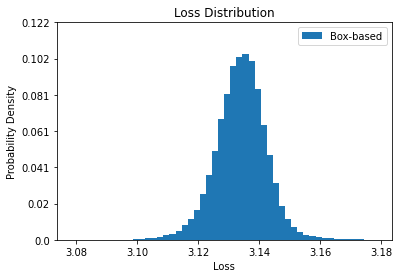

In [54]:
import matplotlib.pyplot as plt
def display_data_hist(loss):
    plt.hist(loss, bins=50, label='Box-based')
    plt.title('Loss Distribution')
    plt.xlabel('Loss')
    plt.ylabel('Probability Density')
    locs, _ = plt.yticks()
    plt.yticks(locs,np.round(locs/loss.shape[0],3))
    plt.legend()
    plt.show()
display_data_hist(expected_losses)

## ViT

In [17]:
# train all ViT parameters
estimated_loss_path = "../../ViT-pytorch/output/ViT-feature-det-ordinal_losses_50000.json"
estimated_loss = np.array(read_one_image_results(estimated_loss_path)['losses'])
file_path = result_json_path + "ViT_runs_50000.json"
active_testing_without_repeated(file_path, true_losses, estimated_loss, "ViT", img_idxes, label_idxes)

In [24]:
# only train part of ViT parameters, freeze transformer part
estimated_loss_path = "/workspace/ViT-pytorch/output/ViT-train-with-test_retrain_losses.json"
estimated_loss = np.array(read_one_image_results(estimated_loss_path)['losses'])
file_path = result_json_path + "ViT_test_retrain_R50_31_10_runs.json"
active_testing_without_repeated(file_path, losses, estimated_loss, "ViT Test Retrain", img_idxes, label_idxes)

In [12]:
# only train part of ViT parameters, freeze transformer part
estimated_loss_path = "/workspace/ViT-pytorch/output/ViT-train-20000_losses.json"
estimated_loss = np.array(read_one_image_results(estimated_loss_path)['losses'])
file_path = result_json_path + "ViT_R50_31_10_runs.json"
active_testing_without_repeated(file_path, losses, estimated_loss, "ViT", img_idxes, label_idxes)

In [14]:
# feature ViT
estimated_loss_path = "/workspace/ViT-pytorch/output/ViT-feature-train-with-test_losses.json"
estimated_loss = np.array(read_one_image_results(estimated_loss_path)['losses'])
file_path = result_json_path + "ViT_feature_test_R50_31_10_runs.json"
active_testing_without_repeated(file_path, losses, estimated_loss, "ViT feature test", img_idxes, label_idxes)

In [23]:
estimated_loss_path = "/workspace/ViT-pytorch/output/ViT-feature-Nearest-train-60000-without-warmup_losses.json"
estimated_loss = np.array(read_one_image_results(estimated_loss_path)['losses'])
file_path = result_json_path + "ViT_feature_train_R50_31_10_without_warmup_runs.json"
active_testing_without_repeated(file_path, losses, estimated_loss, "ViT feature", img_idxes, label_idxes)